# SageMaker Studioで深層学習モデルの学習を加速・コスト最適化する

データ量が増えてきて、深層学習モデルの学習に時間がかかりすぎていませんか？

このノートブックでは、深層学習モデルの学習にかかる時間とコストを最適化する手順を、SageMaker Data Parallelism LibraryとSageMaker Debuggerを使いながらご紹介します。

SageMaker Data Parallelism Libraryは、AWS上での分散学習実行に最適化されているため、HorovodやPyTorch DDPなどの他の分散学習フレームワークに比べて並列化効率がより高いことが証明されています。

今回は、例としてMask RCNNモデルに[COCO2017データセット](https://cocodataset.org/#home)をゼロから学習するのにかかる時間とコストのトレードオフを見ていきます。

なお、このノートブックはSageMaker Studio上のPython 3 (PyTorch 1.6 Python 3.6 GPU Optimized)環境で動作確認をしております。

他のフレームワークやモデルでの分散学習のスクリプトは[こちら](https://github.com/HerringForks/DeepLearningExamples)を参照してください。

## 学習時間と課金額のトレードオフでトータルコスト最適化を考える

SageMaker上で分散学習を実施することで、時間とお金のトレードオフがコントロールできるようになります。

インスタンスの使用料金をPドル/時、学習にかかる時間をT時間、並列化効率(インスタンス x個で学習時間がx倍にどれくらい近くなるか)をS%として、１個のインスタンス（またはGPU）からN個のインスタンス（またはGPU）に分散学習する場合を考えてみましょう。

学習にかかる時間はT時間から(T/N)/S時間に減り、インスタンス使用料金はT * Pドルから(T/N)/S * P * N = T/S * Pドルへ（S = 1、すなわち並列化効率100%とならない限りは）増加します。並列化効率が十分高ければ、大幅な学習時間短縮を少ない金額の増加で買うことができる、というわけです。コストを時間とお金と捉えると、分散学習が１つのコスト最適化のツールとなり、かつ並列化効率がそのトレードオフを決定する重要な要因であることがご理解いただけると思います。

例えば、p3.2xlargeインスタンスで24時間学習に時間を取られている場合、8つのインスタンスに90%の並列化効率で分散学習が実現できれば、時間とコストは以下のように変化します。

分散学習なしでは24 * 3.825 = 91.8ドル（us-west-2リージョンで[SageMaker Savings Plan](https://aws.amazon.com/about-aws/whats-new/2021/04/amazon-sagemaker-announces-a-price-reduction-in-instances-and-sagemaker-savings-plan/)を使用しない場合）のお金と24時間という時間がかかります。

上記の条件で分散学習をすると、24/0.9 * 3.825 = 102ドルのお金と24/8/0.9 = 3.33時間という時間になります。

約11%の金額増加で約86%も学習時間を短縮できるのです。どちらのトータルコストが良いかどうかは、ビジネス上で深層学習のモデル学習時間短縮がどれくらい重要かによります。しかし、モデルを何度も再学習する必要に迫られる中で、これからデータ量が増えていくことが予測されるならば、分散学習というツールを１つの選択肢として持っておくのは悪くないかもしれません。

※この例だと、p3.2xlargeインスタンスを８個のインスタンスにスケールアウトする他に、8個のGPUをもつp3.16xlargeインスタンスを1個使うという方法もあります。これも同様に今回紹介する分散学習の手法としては変わりません。

### 分散学習すべきかを判断するには並列化効率が鍵

分散学習をする上で、鍵となるのは並列化効率です。どのくらいの並列化効率があれば、

実際に現在の深層学習モデルの学習にかかっている時間とインスタンスの料金をもとに、トータルコストをシミュレーションしてみましょう。

SageMakerインスタンスの料金は[こちら](https://aws.amazon.com/jp/sagemaker/pricing/?nc1=h_ls)を参照してください。

これで目指すべき並列化効率が求められます。

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# 学習に何時間かかっているか
TRAINING_TIME = 24

# インスタンスに時間あたり何ドルかかっているか
INSTANCE_PRICE = 3.825

# 何個インスタンスを使うか
NUM_INSTANCES = 8

# １時間学習が長くなることによる機会費用 (トータルコストをドルで統一するため)
TIME_VALUE = 3

In [65]:
def before_total_cost(T, P, weight):
    # トータルコスト = お金 + 時間
    return T * P + T * weight

def after_total_cost(T, P, N, weight, S):
    return T/S * P + T/N/S * weight

In [93]:
def plot_simulation(T, P, N, weight):
    '''
    横軸: 並列化効率
    縦軸: トータルコスト（ドル）
    分散学習をする場合、最低でもどのくらいの並列化効率が必要かをグラフから目安をつける
    '''
    # 並列化効率を10% ~ 100%までシミュレーション
    scaling_efficiencies = list(np.arange(0.10, 1.01, 0.01))
    
    before = []
    after = []
    for S in scaling_efficiencies:
        before_cost = before_total_cost(TRAINING_TIME, INSTANCE_PRICE, TIME_VALUE)
        before.append(before_cost)
        after_cost = after_total_cost(TRAINING_TIME, INSTANCE_PRICE, NUM_INSTANCES, TIME_VALUE, S)
        after.append(after_cost)
        if round(S*100) % 10 == 0:
            is_cost_lower = after_cost < before_cost
            cost_diff = abs((after_cost - before_cost) / before_cost) * 100
            up = "上がる"
            down = "下がる"
            print(f"並列化効率 {S*100:.1f}%でトータルコストは{cost_diff:.3f}% {down if is_cost_lower else up}")
    print()
    plt.plot(scaling_efficiencies, before, label="before")
    plt.plot(scaling_efficiencies, after, label="after")
    plt.legend()

並列化効率 10.0%でトータルコストは515.385% 上がる
並列化効率 20.0%でトータルコストは207.692% 上がる
並列化効率 30.0%でトータルコストは105.128% 上がる
並列化効率 40.0%でトータルコストは53.846% 上がる
並列化効率 50.0%でトータルコストは23.077% 上がる
並列化効率 60.0%でトータルコストは2.564% 上がる
並列化効率 70.0%でトータルコストは12.088% 下がる
並列化効率 80.0%でトータルコストは23.077% 下がる
並列化効率 90.0%でトータルコストは31.624% 下がる
並列化効率 100.0%でトータルコストは38.462% 下がる



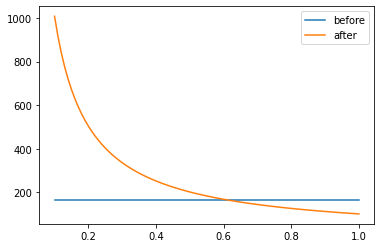

In [94]:
plot_simulation(TRAINING_TIME, INSTANCE_PRICE, NUM_INSTANCES, TIME_VALUE)

この例だと、1時間学習時間が長くなることで平均３ドルほどの機会費用が発生すると仮定してみると、最低でも並列化効率が60%トータルコストは下がらないことがわかります。逆に、

## 0. 準備

- SageMaker Data Parallel Libraryを使用する場合、ml.p3.16xlarge, ml.p3dn.24xlarge [推奨], ml.p4d.24xlarge [推奨]の３種類のインスタンスに対応しています。必要に応じて、上限申請をしてください。

- このデモはSageMaker Studio上で実行してください。

- このデモは以下のIAM権限が必要です。SageMaker Studioのユーザーがこの権限を持っていることを確かめて進めてください。

In [95]:
%%time
import sys
! {sys.executable} -m pip install --upgrade sagemaker
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import boto3

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
fsx_client = boto3.client('fsx')

role = get_execution_role() # provide a pre-existing role ARN as an alternative to creating a new role
print(f'SageMaker Execution Role:{role}')

client = boto3.client('sts')
account = client.get_caller_identity()['Account']
print(f'AWS account:{account}')

session = boto3.session.Session()
region = session.region_name
print(f'AWS region:{region}')

subnets=['<SUBNET_ID>'] # this will be used for FSx and will be where the training job runs. Example: subnet-0f9XXXX
security_group_ids=['<SECURITY_GROUP_ID>'] # Example: sg-03ZZZZZZ

     |████████████████████████████████| 412 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 1.3 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 463 kB/s  eta 0:00:01
     |████████████████████████████████| 101 kB 1.6 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.41.0-py2.py3-none-any.whl size=578905 sha256=ee9ba7182328a2504d49a6694498c4c8d78a4178b015e4361140e7e61a4246ef
  Stored in directory: /root/.cache/pip/wheels/2a/7b/2b/ed8581237f4eee110d1479919514d76f00a9fb9fe9c1feacde
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.35.0
    Uninstalling sagemaker-2.35.0:
      Successfully uninstalled sagemaker-2.35.0
SageMaker Execution Role:arn:aws:iam::330733765668:role/sm-vpc-efs-ExecutionRole-1HQF1ZQFVIHPW
AWS account:330733765668
AWS region:us-west-2
CPU times: user 653 ms, sys: 85.4 ms, total: 739 ms
Wall time: 5.28 s


## 1. COCO2017データセットの準備

[COCO2017](https://cocodataset.org/#home)のデータセットをこのセッションに付随するS3のバケットにダウンロードします。

このスクリプトは20分ほど実行に時間がかかります。

In [ ]:
%%time
!bash ./upload_coco2017_to_s3.sh {bucket} fsx_sync/train-coco/coco

Create stage directory: /root/SageMaker/coco-2017-2021-05-24-03-25-19
download: s3://fast-ai-coco/train2017.zip to ../SageMaker/coco-2017-2021-05-24-03-25-19/train2017.zip
Extracting /root/SageMaker/coco-2017-2021-05-24-03-25-19/train2017.zip
============================================================================================================================================================================================================================================Done.
download: s3://fast-ai-coco/val2017.zip to ../SageMaker/coco-2017-2021-05-24-03-25-19/val2017.zip
Extracting /root/SageMaker/coco-2017-2021-05-24-03-25-19/val2017.zip
==========Done.
download: s3://fast-ai-coco/annotations_trainval2017.zip to ../SageMaker/coco-2017-2021-05-24-03-25-19/annotations_trainval2017.zip
Archive:  /root/SageMaker/coco-2017-2021-05-24-03-25-19/annotations_trainval2017.zip
  inflating: /root/SageMaker/coco-2017-2021-05-24-03-25-19/annotations/instances_train2017.json  
  inflating: /roo

## 2. SageMakerの実行環境を準備

1. デフォルトでSageMakerは最新のPyTorch学習用イメージを[Amazon Deep Learning Container Images (DLC)](https://github.com/aws/deep-learning-containers/blob/master/available_images.md)から使用します。今回は、これをベースイメージとして、MaskRCNNモデルを学習するのに必要な追加のモジュールをインストールしていきます。
2. PyTorch-SMDataParallel MaskRCNN学習スクリプトがGitHubレポジトリ https://github.com/HerringForks/DeepLearningExamples.git からダウンロードでき、今回はこれを学習用イメージの上にインストールします。

### 2.1. Dockerイメージをビルド・ECRへプッシュ

以下のコマンドを実行して、DockerイメージをビルドしてECRへプッシュしてみましょう。

In [129]:
image = "mask-rcnn-smdataparallel-demo"  # 例: mask-rcnn-smdataparallel-sagemaker
tag = "test0.1"   # 例: pt1.8 

In [120]:
!pygmentize ./Dockerfile

ARG region

FROM 763104351884.dkr.ecr.${region}.amazonaws.com/pytorch-training:1.8.1-gpu-py36-cu111-ubuntu18.04

RUN pip install ninja yacs cython matplotlib tqdm opencv-python pybind11==2.5.0 'git+https://github.com/NVIDIA/dllogger'

RUN pip --no-cache-dir --no-cache install 'git+https://github.com/NVIDIA/cocoapi#egg=pycocotools&subdirectory=PythonAPI'

RUN 	cd /root && \
	rm -rf apex && \
	git clone https://github.com/NVIDIA/apex && \
	cd apex && \
	python setup.py install --cuda_ext --cpp_ext

RUN 	cd /root && \
	rm -rf DeepLearningExamples && \
	git clone --recursive https://github.com/HerringForks/DeepLearningExamples.git && \
	cd DeepLearningExamples/PyTorch/Segmentation/MaskRCNN/pytorch/ && \
	python setup.py build develop


In [121]:
!pygmentize ./build_and_push.sh

#!/usr/bin/env bash
# This script shows how to build the Docker image and push it to ECR to be ready for use
# by SageMaker.
# The argument to this script is the image name. This will be used as the image on the local
# machine and combined with the account and region to form the repository name for ECR.
# set region

DIR="$( cd "$( dirname "${BASH_SOURCE[0]}" )" && pwd )"

if [ "$#" -eq 3 ]; then
    region=$1
    image=$2
    tag=$3
else
    echo "usage: $0 <aws-region> $1 <image-repo> $2 <image-tag>"
    exit 1
fi

# Get the account number associated with the current IAM credentials
# account=$(aws sts get-caller-identity --query Account --output text)
AWS_ACCOUNT_ID=$(aws sts get-caller-identity --query Account --output text)
AWS_DEFAULT_REGION=$region
IMAGE_REPO_NAME=$image
IMAGE_TAG=$tag

if [ $? -ne 0 ]
then
    exit 255
fi


# fullname="${account}.dkr.ecr.${region}.amazonaws.com/${image}:${tag}"
fullname="{$AWS_ACCOUNT_ID}.dkr.ecr.{$AWS_DEFAULT_REGION}.amazonaws.com/{$IMAGE_REP

In [122]:
# SageMaker Studio上でDocker buildを行うためのモジュールをインストール
! pip install sagemaker-studio-image-build

In [130]:
%%time
! chmod +x build_and_push.sh; bash build_and_push.sh {region} {image} {tag}

...[Container] 2021/05/25 00:54:42 Waiting for agent ping

[Container] 2021/05/25 00:54:45 Waiting for DOWNLOAD_SOURCE
[Container] 2021/05/25 00:54:46 Phase is DOWNLOAD_SOURCE
[Container] 2021/05/25 00:54:46 CODEBUILD_SRC_DIR=/codebuild/output/src062085026/src
[Container] 2021/05/25 00:54:46 YAML location is /codebuild/output/src062085026/src/buildspec.yml
[Container] 2021/05/25 00:54:46 Processing environment variables
[Container] 2021/05/25 00:54:46 No runtime version selected in buildspec.
[Container] 2021/05/25 00:54:46 Moving to directory /codebuild/output/src062085026/src
[Container] 2021/05/25 00:54:46 Registering with agent
[Container] 2021/05/25 00:54:46 Phases found in YAML: 3
[Container] 2021/05/25 00:54:46  PRE_BUILD: 9 commands
[Container] 2021/05/25 00:54:46  BUILD: 4 commands
[Container] 2021/05/25 00:54:46  POST_BUILD: 3 commands
[Container] 2021/05/25 00:54:46 Phase complete: DOWNLOAD_SOURCE State: SUCCEEDED
[Container] 2021/05/25 00:54:46 Phase context status code:  M

### 2.2. 閉域網内で学習・推論する場合

学習・推論を閉域網(VPC)内で、インターネットを介さない状態で実行する必要がある場合、以下のコマンドであらかじめベースとなるモデルをダウンロードする必要がある。

In [ ]:
# !wget https://dl.fbaipublicfiles.com/detectron/ImageNetPretrained/MSRA/R-50.pkl 
# !aws s3 cp R-50.pkl s3://{bucket}/pretrained_weights/R-50.pkl

### 2.3. 学習時に収集するメトリクスを定義する

学習ジョブの状態をよく把握するために、アルゴリズムに対するメトリクスを定義します。SageMakerは学習ジョブのログをスクレープして、学習ジョブのコンソールまたはSageMaker Experimentsに吐き出します。

以下のように正規表現でフィルターをかけ、追跡したいメトリクスを定義します。

In [ ]:
metric_definitions=[{
        "Name": "loss",
        "Regex": ".*loss:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_classifier",
        "Regex": ".*loss_cls:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_box_reg",
        "Regex": ".*loss_box_reg:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_mask",
        "Regex": ".*loss_mask:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_objectness",
        "Regex": ".*loss_objectness:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "loss_rpn_box_reg",
        "Regex": ".*loss_rpn_box_reg:\s([0-9\\.]+)\s*"
    }, 
    {
        "Name": "overall_training_speed",
        "Regex": ".*Overall training speed:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "lr",  
        "Regex": ".*lr:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "iter",  
        "Regex": ".*iter:\s([0-9\\.]+)\s*"
    },
    {
        "Name": "avg iter/s",  
        "Regex": ".*avg iter/s:\s([0-9\\.]+)\s*"
    },

]

## 3. インスタンス１つで学習してみる

<インスタンス１つで学習を回すのにかかる時間とスクショ>

`Estimator`というクラス（を継承した`PyTorch`クラス）に対して、学習ジョブで使うインスタンスの種類と数を選びます。ここでは、まず１つのインスタンスで学習ジョブを実行して、どのくらいの時間がかかるかみてみましょう。

In [ ]:
import os
import time
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig

In [ ]:
# SageMaker Debuggerを活用するため
profiler_config = ProfilerConfig(system_monitor_interval_millis=500)

In [ ]:
instance_type = "ml.p3dn.24xlarge" # Other supported instance type: ml.p3.16xlarge, ml.p4d.24xlarge
instance_count = 1 # You can use 2, 4, 8 etc.
docker_image = f"{account}.dkr.ecr.{region}.amazonaws.com/{image}:{tag}" # YOUR_ECR_IMAGE_BUILT_WITH_ABOVE_DOCKER_FILE
username = 'AWS'
job_name = f'pytorch-smdataparallel-mrcnn-fsx-{int(time.time())}' # This job name is used as prefix to the sagemaker training job. Makes it easy for your look for your training job in SageMaker Training job console.
config_file = 'e2e_mask_rcnn_R_50_FPN_1x_16GPU_4bs.yaml'

In [ ]:
hyperparameters = {
 "config-file": config_file,
 "skip-test": "",
 "seed": 987,
 "dtype": "float16",
 "spot_ckpt":f"s3://{bucket}/pretrained_weights/R-50.pkl", # this is where our script will look for existing weights to initialize the model backbone from.
}

In [ ]:
estimator = PyTorch(entry_point='train_pytorch_single_maskrcnn.py',
                    role=role,
                    image_uri=docker_image,
                    source_dir='.',
                    instance_count=instance_count,
                    instance_type=instance_type,
                    framework_version='1.8.0',
                    py_version='py36',
                    sagemaker_session=sagemaker_session,
                    metric_definitions = metric_definitions,
                    hyperparameters=hyperparameters, 
                    subnets=subnets, 
                    security_group_ids=security_group_ids,
                    debugger_hook_config=False,
                    profiler_config=profiler_config,
                   )

### 3.1 SageMaker Debuggerでプロファイリングする

## 4. 分散学習用のコードを追加する

どこの行に何を追加するのか

また、それはなぜか


## 5. 1つのインスタンスにある複数GPUをフル活用して分散学習



### 5.1 プロファイリングしてボトルネックを探す

ここでIOとコンピュートにボトルネック発見

## 6. FSx for Lustreを使ってIOを加速する

FSx for Lustreを配置するためのVPCサブネットとセキュリティグループを設定して以下に入力する。

In [ ]:
subnets=['<SUBNET_ID>'] # this will be used for FSx and will be where the training job runs. Example: subnet-0f9XXXX
security_group_ids=['<SECURITY_GROUP_ID>'] # Example: sg-03ZZZZZZ

In [ ]:
# use boto3 to create FSx 

fsx_response = fsx_client.create_file_system(
      FileSystemType='LUSTRE',
      StorageCapacity=1200,
      StorageType='SSD',
      SubnetIds= subnets,
      SecurityGroupIds= security_group_ids,
      Tags=[
          {
              'Key': 'Name',
              'Value': 'COCO-storage'
          },
      ],
      LustreConfiguration={
          'WeeklyMaintenanceStartTime': '7:03:00',
          'ImportPath': f's3://{bucket}/fsx_sync/', # where FSx will import data from in s3, can do entire bucket or a specific folder
          'ImportedFileChunkSize': 1024,
          'DeploymentType': 'PERSISTENT_1', # |'SCRATCH_1' |'SCRATCH_2' # PERSISTENT means the storage in FSx will be persistent, SCRATCH indicates the storage is temporary
          'AutoImportPolicy': 'NEW', # 'NONE'| |'NEW_CHANGED' # this policy is how often data will be imported to FSx from S3
          'PerUnitStorageThroughput':200 # this is specific to PERSISTENT storage, not required for temporary
      }
  )

fsx_response

In [ ]:
file_system_id= fsx_response['FileSystem']['FileSystemId'] # FSx file system ID with your training dataset. Example: 'fs-0bYYYYYY'

In [ ]:
estimator = PyTorch(entry_point='train_pytorch_smdataparallel_maskrcnn.py',
                    role=role,
                    image_uri=docker_image,
                    source_dir='.',
                    instance_count=instance_count,
                    instance_type=instance_type,
                    framework_version='1.8.0',
                    py_version='py36',
                    sagemaker_session=sagemaker_session,
                    metric_definitions = metric_definitions,
                    hyperparameters=hyperparameters, 
                    subnets=subnets, 
                    security_group_ids=security_group_ids,
                    debugger_hook_config=False,
                    # Training using SMDataParallel Distributed Training Framework
                    distribution={'smdistributed':{
                                    'dataparallel':{
                                            'enabled': True
                                         }
                                      }
                                  }
           )

In [ ]:
# Configure FSx Input for your SageMaker Training job

from sagemaker.inputs import FileSystemInput
file_system_directory_path= 'YOUR_MOUNT_PATH_FOR_TRAINING_DATA' # NOTE: '/fsx/' will be the root mount path. Example: '/fsx/mask_rcnn/PyTorch'
file_system_access_mode='ro'
file_system_type='FSxLustre'
train_fs = FileSystemInput(file_system_id=file_system_id,
                                    file_system_type=file_system_type,
                                    directory_path=file_system_directory_path,
                                    file_system_access_mode=file_system_access_mode)
data_channels = {'train': train_fs}

In [ ]:
# Submit SageMaker training job
estimator.fit(inputs=data_channels, job_name=job_name)

## 7. 複数インスタンスで分散学習

合計は速い？